### Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


### Import pandas

In [2]:
import pandas as pd

# Path hasil download dari kagglehub
file_path = path + "/IMDB Dataset.csv"

# Baca CSV
df = pd.read_csv(file_path)

# Cek isi
print(df.head())
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Simple preprocessing

In [3]:
import re

def clean_text(text):
    # lowercase
    text = text.lower()
    # remove html tags
    text = re.sub(r"<.*?>", "", text)
    # keep only letters
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df['clean_review'] = df['review'].apply(clean_text)

### Split data

In [4]:
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Vektorisasi kata

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # batasi 5000 kata biar cepat
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Pelatihan model

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

###Evaluasi model

              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



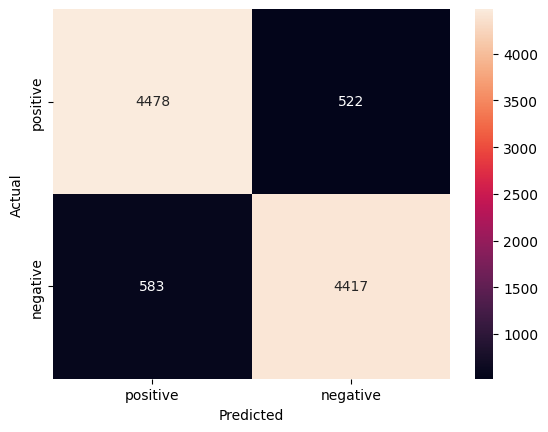

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_vec)

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive','negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

###Hyperparameter tuning

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Grid hyperparameter
param_grid = {
    "C": [0.1, 1.0, 10.0],
    "solver": ["liblinear", "lbfgs"]
}

results = []
best_model = None
best_score = 0
best_params = {}

# Hyperparameter tuning loop
for C in param_grid["C"]:
    for solver in param_grid["solver"]:
        try:
            model = LogisticRegression(max_iter=1000, C=C, penalty="l2", solver=solver)
            model.fit(X_train_vec, y_train)
            y_val_pred = model.predict(X_test_vec)

            acc = accuracy_score(y_test, y_val_pred)
            f1 = f1_score(y_test, y_val_pred, pos_label="positive")

            results.append((C, solver, acc, f1))

            # simpan model terbaik
            if f1 > best_score:
                best_score = f1
                best_model = model
                best_params = {"C": C, "solver": solver}

        except Exception as e:
            print(f"Error for C={C}, solver={solver}:", e)

# Ringkasan hasil tuning
df_results = pd.DataFrame(results, columns=["C", "Solver", "Accuracy", "F1_Positive"])
print("\n=== Hasil Hyperparameter Tuning Logistic Regression ===")
print(df_results.sort_values(by="F1_Positive", ascending=False))

print("\n✅ Model terbaik:", best_params, "| F1_Positive:", best_score)


=== Hasil Hyperparameter Tuning Logistic Regression ===
      C     Solver  Accuracy  F1_Positive
3   1.0      lbfgs    0.8895     0.890170
2   1.0  liblinear    0.8892     0.889926
5  10.0      lbfgs    0.8884     0.888977
4  10.0  liblinear    0.8863     0.886899
1   0.1      lbfgs    0.8723     0.873951
0   0.1  liblinear    0.8715     0.873262

✅ Model terbaik: {'C': 1.0, 'solver': 'lbfgs'} | F1_Positive: 0.8901699632243316


###Evaluasi hasil hyperparameter


--- Classification Report (Best Model) ---
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



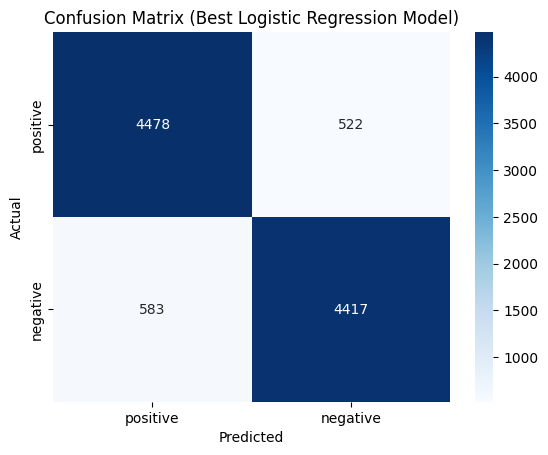

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi dengan model terbaik
y_best_pred = best_model.predict(X_test_vec)

print("\n--- Classification Report (Best Model) ---")
print(classification_report(y_test, y_best_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_best_pred, labels=['positive','negative'])
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['positive','negative'],
            yticklabels=['positive','negative'],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Best Logistic Regression Model)")
plt.show()